In [1]:
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import numpy as np
import gzip
import math
import linmix
np.random.seed(2)

In [2]:
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 16
plt.rcParams['xtick.minor.size'] = 9
plt.rcParams['ytick.major.size'] = 16
plt.rcParams['ytick.minor.size'] = 9
plt.rcParams['ytick.minor.size'] = 9
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['ytick.minor.width'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['xtick.minor.width'] = 2.5
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.pad'] = 9
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True
plt.rcParams['axes.titlesize'] = 30
plt.rcParams.update({'font.size': 30})

In [23]:
fullmergedf = pd.read_csv('fullmergePAB.csv')
dcmergedf = pd.read_csv('dcmergePAB.csv')
dustdf = pd.read_csv('dustdfPAB.csv')
attdf = pd.read_csv('attdfPAB.csv')
fullcleardf = pd.read_csv('clearPAB.csv')

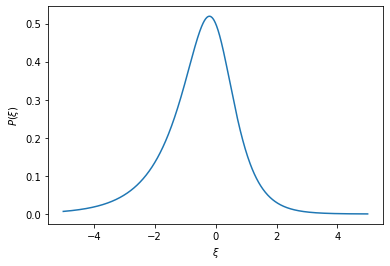

In [2]:
def pxi(xi):
    return np.exp(xi) * (1.0 + np.exp(2.75*xi))**(-1)
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(-5,5, 0.01)
ax.plot(x, pxi(x))
ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$P(\xi)$")
plt.show()

In [3]:
def rejection_sample(p, pmax, prop, size):
    out=[]
    for s in range(size):
        x = prop()
        px = p(x)
        pu = np.random.uniform(low=0.0, high=pmax)
        while px < pu:
            x = prop()
            px = p(x)
            pu = np.random.uniform(low=0.0, high=pmax)
        out.append(x)
    return np.array(out)
pmax = 0.55 # max p(xi) determined by eye
prop = lambda : np.random.uniform(low=-10, high=10) # truncating range to (-10, 10)
xi = rejection_sample(pxi, pmax, prop, size=100)

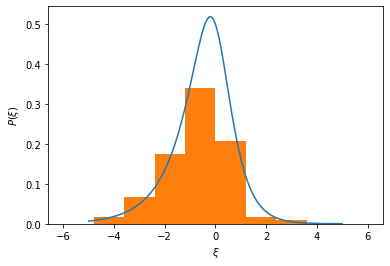

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(-5,5, 0.01)
ax.plot(x, pxi(x))
ax.hist(xi, 10, range=(-6,6), density=True)
ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$P(\xi)$")
plt.show()

In [6]:
alpha = 1.0
beta = 0.5
sigsqr = 0.75**2
epsilon = np.random.normal(loc=0, scale=np.sqrt(sigsqr), size=len(xi))
eta = alpha + beta*xi + epsilon

In [7]:
tau = np.std(xi)
sigma = np.sqrt(sigsqr)
t = 0.4 * tau
s = 0.5 * sigma
xsig = 5*t**2 / np.random.chisquare(5, size=len(xi))
ysig = 5*s**2 / np.random.chisquare(5, size=len(eta))
x = np.random.normal(loc=xi, scale=xsig)
y = np.random.normal(loc=eta, scale=ysig)

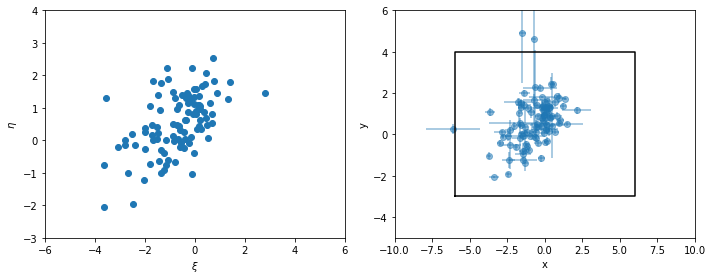

In [8]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(xi, eta)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$\eta$')
ax.set_xlim(-6,6)
ax.set_ylim(-3,4)
ax = fig.add_subplot(122)
ax.scatter(x, y, alpha=0.5)
ax.errorbar(x, y, xerr=xsig, yerr=ysig, ls=' ', alpha=0.5)
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_xlim(-10,10)
ax.set_ylim(-5,6)
ax.plot([-6,6,6,-6,-6], [-3,-3,4,4,-3], color='k')
fig.tight_layout()
plt.show()

In [22]:
lm = linmix.LinMix(x, y, xsig, ysig , K = 2, seed = 2)
lm.run_mcmc(silent = True)

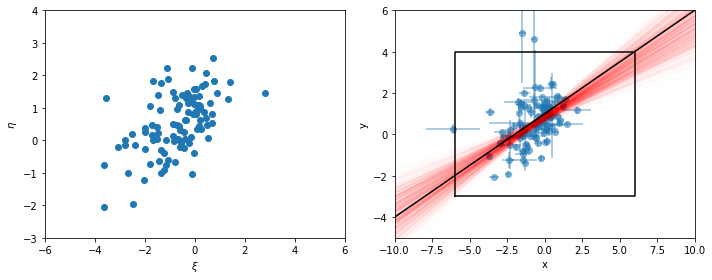

In [20]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.scatter(xi, eta)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$\eta$')
ax.set_xlim(-6,6)
ax.set_ylim(-3,4)
ax = fig.add_subplot(122)
ax.scatter(x, y, alpha=0.5)
ax.errorbar(x, y, xerr=xsig, yerr=ysig, ls=' ', alpha=0.5)
for i in range(0, len(lm.chain), 25):
    xs = np.arange(-10,11)
    ys = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)
ys = alpha + xs * beta
ax.plot(xs, ys, color='k')
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_xlim(-10,10)
ax.set_ylim(-5,6)
ax.plot([-6,6,6,-6,-6], [-3,-3,4,4,-3], color='k')
fig.tight_layout()

In [7]:
lmre = linmix.LinMix(fullmergedf['gf_re_j'][fullmergedf['gf_f_j'] == 0], fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0], fullmergedf['gf_dre_j'][fullmergedf['gf_f_j'] == 0], fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['gf_f_j'] == 0] , K = 2, seed = 2)
lmre.run_mcmc(silent = True) 

lmn = linmix.LinMix(fullmergedf['gf_n_j'][fullmergedf['gf_f_j'] == 0], fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0], fullmergedf['gf_dn_j'][fullmergedf['gf_f_j'] == 0], fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['gf_f_j'] == 0] , K = 2, seed = 2)
lmn.run_mcmc(silent = True) 

lmsigma = linmix.LinMix(fullmergedf['SIGMA_1'][fullmergedf['gf_f_j'] == 0], fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0], [.3]* len(fullmergedf['SIGMA_1'][fullmergedf['gf_f_j'] == 0]), fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['gf_f_j'] == 0] , K = 2, seed = 2)
lmsigma.run_mcmc(silent = True) 

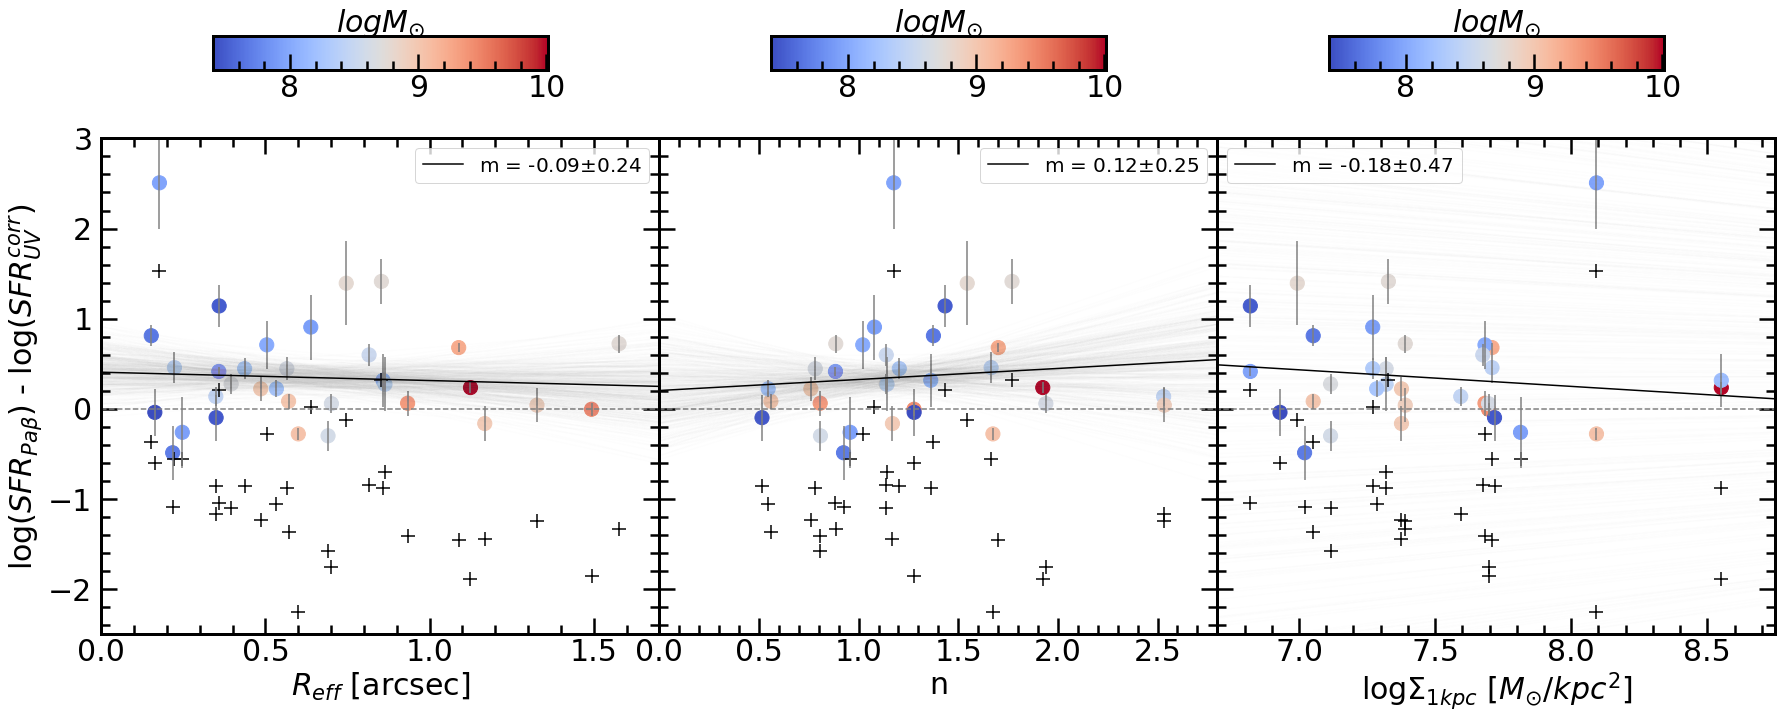

In [9]:
fig = plt.figure(figsize = (30 , 11))
gs = GridSpec(nrows=12, ncols=15)
gs.update(wspace = 0, hspace = 0.5)

ax0 = fig.add_subplot(gs[2:12, 0:5])
ax0.set_ylabel(r'log($SFR_{Pa\beta}$) - log($SFR_{UV}^{corr}$)')
ax0.set_xlabel(r"$R_{eff}$ [arcsec]")
y0 = ax0.scatter(fullmergedf['gf_re_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , s = 200 , c = fullmergedf['td_lmass'][fullmergedf['gf_f_j'] == 0] , cmap = 'coolwarm')
ax0.errorbar(fullmergedf['gf_re_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , yerr = fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['gf_f_j'] == 0] , c = 'gray',  linestyle = 'None')
ax0.scatter(fullmergedf['gf_re_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX_LL_1SIGMA'][fullmergedf['gf_f_j'] == 0] , s = 200 , marker = '+' , c = 'black')
ax0.axis([0 , 1.7 , -2.5 , 3])
ax0.plot([0 , 2] , [0 , 0] , '--' , c = 'gray')
for i in range(0, len(lmre.chain), 25):
    xs = np.arange(-4,4)
    ys = lmre.chain[i]['alpha'] + xs * lmre.chain[i]['beta']
    ax0.plot(xs, ys, color='gray', alpha=0.01)
ax0.plot([0 , 2] , [np.mean(lmre.chain['alpha']) + np.mean(lmre.chain['beta'])*0 , np.mean(lmre.chain['alpha']) + np.mean(lmre.chain['beta'])*2] , c = 'black' , label = 'm = ' + str(round(np.mean(lmre.chain['beta']) , 2)) + r'$\pm$' + str(round(np.std(lmre.chain['beta']), 2))  )
#ax0.plot(xs, ys, color='k')
ax0.legend()

ax1 = fig.add_subplot(gs[2:12, 5:10])
y1= ax1.scatter(fullmergedf['gf_n_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , s = 200 , c = fullmergedf['td_lmass'][fullmergedf['gf_f_j'] == 0] , cmap = 'coolwarm')
ax1.errorbar(fullmergedf['gf_n_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , yerr = fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['gf_f_j'] == 0] , c = 'gray',  linestyle = 'None')
ax1.scatter(fullmergedf['gf_n_j'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX_LL_1SIGMA'][fullmergedf['gf_f_j'] == 0] , s = 200 , marker = '+' , c = 'black')
ax1.plot([0 , 8] , [0 , 0] , '--' , c = 'gray')
ax1.set_xlabel(r"n")
ax1.axis([0 , 2.8 , -2.5 , 3])
ax1.tick_params(labelleft = False)
for i in range(0, len(lmn.chain), 25):
    xsn = np.arange(-4,4)
    ysn = lmn.chain[i]['alpha'] + xsn * lmn.chain[i]['beta']
    ax1.plot(xsn, ysn, color='gray', alpha=0.01)

ax1.plot([0 , 8] , [np.mean(lmn.chain['alpha']) + np.mean(lmn.chain['beta'])*0 , np.mean(lmn.chain['alpha']) + np.mean(lmn.chain['beta'])*8] , c = 'black' , label = 'm = ' + str(round(np.mean(lmn.chain['beta']) , 2)) + r'$\pm$' + str(round(np.std(lmn.chain['beta']), 2)))
ax1.legend()

ax2 = fig.add_subplot(gs[2:12, 10:15])
ax2.set_xlabel(r"log$\Sigma_{1kpc}$ [$M_{\odot}/kpc^2$]")
y2 = ax2.scatter(fullmergedf['SIGMA_1'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , s = 200 , c = fullmergedf['td_lmass'][fullmergedf['gf_f_j'] == 0] , cmap = 'coolwarm')
ax2.errorbar(fullmergedf['SIGMA_1'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX2'][fullmergedf['gf_f_j'] == 0] , yerr = fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['gf_f_j'] == 0] , c = 'gray',  linestyle = 'None')
ax2.scatter(fullmergedf['SIGMA_1'][fullmergedf['gf_f_j'] == 0] , fullmergedf['PAB_SFR_EX_LL_1SIGMA'][fullmergedf['gf_f_j'] == 0] , s = 200 , marker = '+' , c = 'black')
ax2.axis([6.7 , 8.75 , -2.5 , 3])
ax2.plot([0 , 10] , [0 , 0] , '--' , c = 'gray')
ax2.tick_params(labelleft = False)
for i in range(0, len(lmsigma.chain), 25):
    xs = np.arange(3 , 11)
    ys = lmsigma.chain[i]['alpha'] + xsn * lmsigma.chain[i]['beta']
    ax2.plot(xs, ys, color='gray', alpha=0.01)
#ax1.plot(xsn, ysn, color='k')
ax2.plot([0 , 10] , [np.mean(lmsigma.chain['alpha']) + np.mean(lmsigma.chain['beta'])*0 , np.mean(lmsigma.chain['alpha']) + np.mean(lmsigma.chain['beta'])*10] , c = 'black' , label ='m = ' + str(round(np.mean(lmsigma.chain['beta']) , 2)) + r'$\pm$' + str(round(np.std(lmsigma.chain['beta']), 2)))
ax2.legend(loc = 'upper left')

ax3 = fig.add_subplot(gs[0:1,1:4])
fig.colorbar(y0,ax3,use_gridspec=True,orientation='horizontal' ,  label = '$logM_{\odot}$')
ax3.xaxis.set_label_position('top')
ax4 = fig.add_subplot(gs[0:1,6:9])
fig.colorbar(y1,ax4,use_gridspec=True,orientation='horizontal' ,  label = '$logM_{\odot}$')
ax4.xaxis.set_label_position('top')
ax5 = fig.add_subplot(gs[0:1,11:14])
fig.colorbar(y2,ax5,use_gridspec=True,orientation='horizontal' ,  label = '$logM_{\odot}$')
ax5.xaxis.set_label_position('top')
plt.show()

In [10]:
lmmass = linmix.LinMix(fullmergedf['td_lmass'][fullmergedf['ir_UV_beta'] < 0], fullmergedf['PAB_SFR_EX2'][fullmergedf['ir_UV_beta'] < 0], [.3]* len(fullmergedf['td_lmass'][fullmergedf['ir_UV_beta'] < 0]), fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['ir_UV_beta'] < 0], K = 2, seed = 2)
lmmass.run_mcmc(silent = True) 

lmbetaneg = linmix.LinMix(fullmergedf['ir_UV_beta'][fullmergedf['ir_UV_beta'] < 0], fullmergedf['PAB_SFR_EX2'][fullmergedf['ir_UV_beta'] < 0], [.3]* len(fullmergedf['ir_UV_beta'][fullmergedf['ir_UV_beta'] < 0]), fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['ir_UV_beta'] < 0] , K = 2, seed = 2)
lmbetaneg.run_mcmc(silent = True) 

lmbetapos = linmix.LinMix(fullmergedf['ir_UV_beta'][fullmergedf['ir_UV_beta'] > 0], fullmergedf['PAB_SFR_EX2'][fullmergedf['ir_UV_beta'] > 0], [.3]* len(fullmergedf['ir_UV_beta'][fullmergedf['ir_UV_beta'] > 0]), fullmergedf['PAB_SFR_EX2_ERR'][fullmergedf['ir_UV_beta'] > 0] , K = 2, seed = 2)
lmbetapos.run_mcmc(silent = True) 

lmbetaol = linmix.LinMix(fullmergedf['ir_UV_beta'], fullmergedf['PAB_SFR_EX2'], [.3]* len(fullmergedf['ir_UV_beta']), fullmergedf['PAB_SFR_EX2_ERR'] , K = 2, seed = 2)
lmbetaol.run_mcmc(silent = True) 

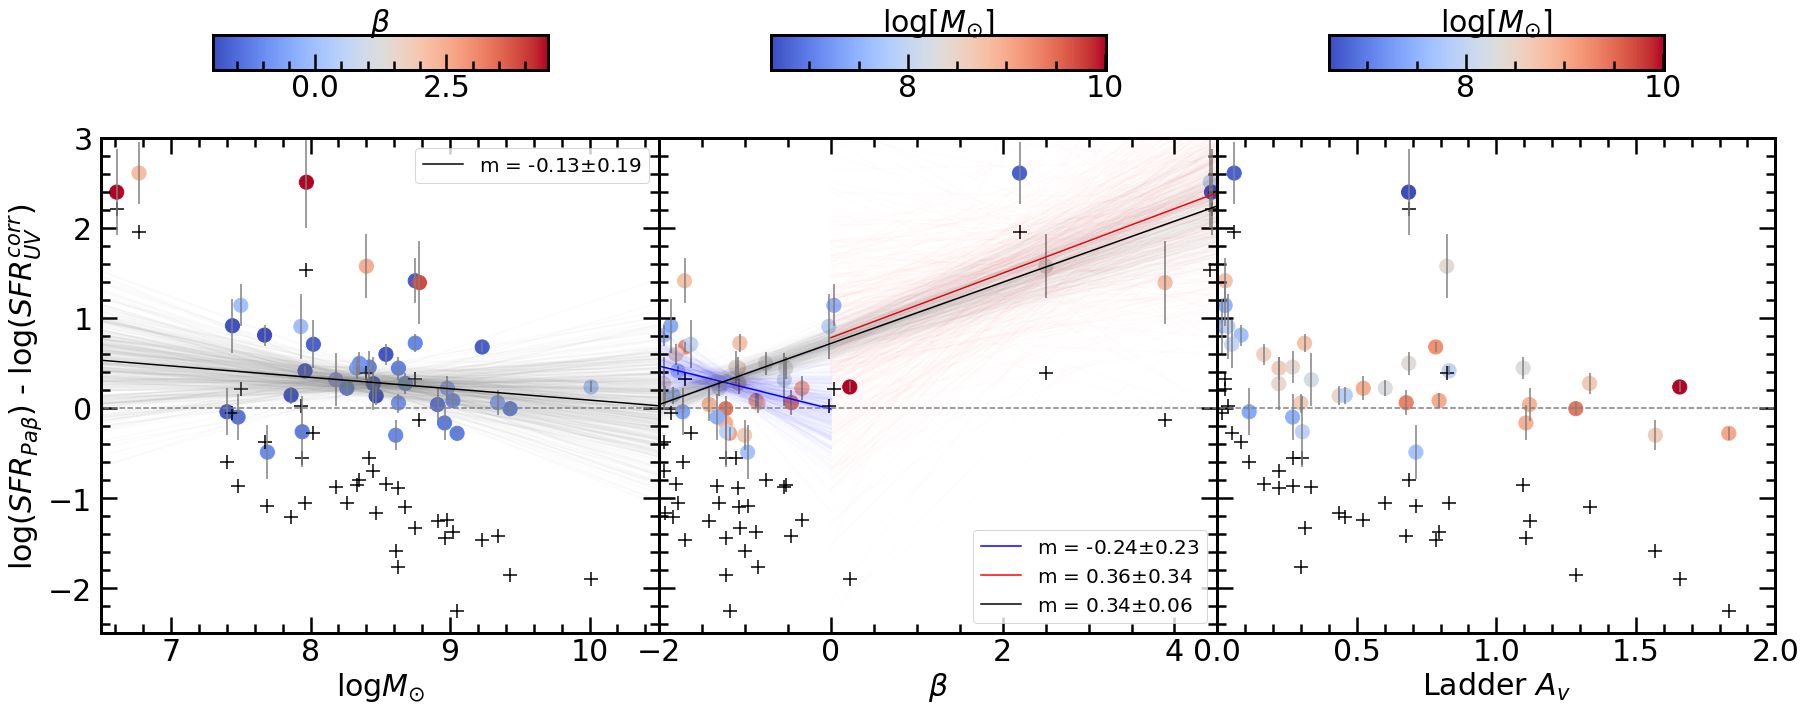

In [12]:
fig = plt.figure(figsize = (30 , 11))
gs = GridSpec(nrows=12, ncols=15)
gs.update(wspace = 0, hspace = 0.5)

ax0 = fig.add_subplot(gs[2:12, 0:5])
y0 = ax0.scatter(fullmergedf['td_lmass'] , fullmergedf['PAB_SFR_EX2'] , s = 200 , c = fullmergedf['ir_UV_beta'] , cmap = 'coolwarm')
ax0.scatter(fullmergedf['td_lmass'] , fullmergedf['PAB_SFR_EX_LL_1SIGMA'] , s = 200 , marker = '+' , c = 'black')
ax0.errorbar(fullmergedf['td_lmass'] , fullmergedf['PAB_SFR_EX2'] , yerr = fullmergedf['PAB_SFR_EX2_ERR'] , c = 'gray',  linestyle = 'None')
for i in range(0, len(lmmass.chain), 25):
    xs = np.arange(6,12)
    ys = lmmass.chain[i]['alpha'] + xs * lmmass.chain[i]['beta']
    ax0.plot(xs, ys, color='gray', alpha=0.03)
ax0.plot([6.5 , 10.5] , [np.mean(lmmass.chain['alpha']) + np.mean(lmmass.chain['beta'])*6.5 , np.mean(lmmass.chain['alpha']) + np.mean(lmmass.chain['beta'])*10.5] , c = 'black' , label = 'm = ' + str(round(np.mean(lmmass.chain['beta']) , 2)) + r'$\pm$' + str(round(np.std(lmmass.chain['beta']), 2))  )

ax0.plot([6 , 11] , [0 , 0] , '--' , c = 'gray')
ax0.set_ylabel(r'log($SFR_{Pa\beta}$) - log($SFR_{UV}^{corr}$)')
ax0.set_xlabel(r"log$M_{\odot}$")
ax0.axis([6.5 , 10.5 , -2.5 , 3])
ax0.legend()

#beta figure
ax1 = fig.add_subplot(gs[2:12, 5:10])
y1 = ax1.scatter(fullmergedf['ir_UV_beta'] , fullmergedf['PAB_SFR_EX2'] , s = 200 , c = fullmergedf['td_lmass'] , cmap = 'coolwarm')
ax1.scatter(fullmergedf['ir_UV_beta'] , fullmergedf['PAB_SFR_EX_LL_1SIGMA'] , s = 200 , marker = '+' , c = 'black')
ax1.errorbar(fullmergedf['ir_UV_beta'] , fullmergedf['PAB_SFR_EX2'] , yerr = fullmergedf['PAB_SFR_EX2_ERR'] , c = 'gray',  linestyle = 'None')
#beta < 0 fit
for i in range(0, len(lmbetaneg.chain), 25):
    xs = np.arange(-2,1)
    ys = lmbetaneg.chain[i]['alpha'] + xs * lmbetaneg.chain[i]['beta']
    ax1.plot(xs, ys, color='blue', alpha=0.01)
ax1.plot([-2 , 0] , [np.mean(lmbetaneg.chain['alpha']) + np.mean(lmbetaneg.chain['beta'])*-2 , np.mean(lmbetaneg.chain['alpha']) + np.mean(lmbetaneg.chain['beta'])*0] , c = 'blue' , label = 'm = ' + str(round(np.mean(lmbetaneg.chain['beta']) , 2)) + r'$\pm$' + str(round(np.std(lmbetaneg.chain['beta']), 2))  )
#beta > 0 fit
for i in range(0, len(lmbetapos.chain), 25):
    xs = np.arange(0,6)
    ys = lmbetapos.chain[i]['alpha'] + xs * lmbetapos.chain[i]['beta']
    ax1.plot(xs, ys, color='red', alpha=0.01)
ax1.plot([0 , 4.5] , [np.mean(lmbetapos.chain['alpha']) + np.mean(lmbetapos.chain['beta'])*0 , np.mean(lmbetapos.chain['alpha']) + np.mean(lmbetapos.chain['beta'])*4.5] , c = 'red' , label = 'm = ' + str(round(np.mean(lmbetapos.chain['beta']) , 2)) + r'$\pm$' + str(round(np.std(lmbetapos.chain['beta']), 2))  )
#beta one line fit
for i in range(0, len(lmbetaol.chain), 25):
    xs = np.arange(-2,6)
    ys = lmbetaol.chain[i]['alpha'] + xs * lmbetaol.chain[i]['beta']
    ax1.plot(xs, ys, color='gray', alpha=0.01)
ax1.plot([-2 , 6] , [np.mean(lmbetaol.chain['alpha']) + np.mean(lmbetaol.chain['beta'])*-2 , np.mean(lmbetaol.chain['alpha']) + np.mean(lmbetaol.chain['beta'])*6] , c = 'black' , label = 'm = ' + str(round(np.mean(lmbetaol.chain['beta']) , 2)) + r'$\pm$' + str(round(np.std(lmbetaol.chain['beta']), 2))  )

ax1.plot([-2.5 , 4.5] , [0 , 0] , '--' , c = 'gray')
ax1.set_xlabel(r"$\beta$")
ax1.axis([-2 , 4.5 , -2.5 , 3])
ax1.tick_params(labelleft = False)
ax1.legend()

ax2 = fig.add_subplot(gs[2:12, 10:15])
y2 = ax2.scatter(fullmergedf['ir_SFR-ladder_total_Av'] , fullmergedf['PAB_SFR_EX2'] , s = 200 , c = fullmergedf['td_lmass'] , cmap = 'coolwarm')
ax2.scatter(fullmergedf['ir_SFR-ladder_total_Av'] , fullmergedf['PAB_SFR_EX_LL_1SIGMA'] , s = 200 , marker = '+' , c = 'black')
ax2.errorbar(fullmergedf['ir_SFR-ladder_total_Av'] , fullmergedf['PAB_SFR_EX2'] , yerr = fullmergedf['PAB_SFR_EX2_ERR'] , ls = 'None' , c = 'gray')
ax2.plot([-2.5 , 4.5] , [0 , 0] , '--' , c = 'gray')
ax2.set_xlabel(r"Ladder $A_v$")
ax2.axis([0 , 2 , -2.5 , 3])
ax2.tick_params(labelleft = False)

ax3 = fig.add_subplot(gs[0:1,1:4])
fig.colorbar(y0,ax3,use_gridspec=True,orientation='horizontal' ,  label = r'$\beta$')
ax3.xaxis.set_label_position('top')
ax4 = fig.add_subplot(gs[0:1,6:9])
fig.colorbar(y1,ax4,use_gridspec=True,orientation='horizontal' ,  label = r'log$[M_{\odot}]$')
ax4.xaxis.set_label_position('top')
ax5 = fig.add_subplot(gs[0:1,11:14])
cb2 = fig.colorbar(y2,ax5,use_gridspec=True,orientation='horizontal' ,  label = r'log$[M_{\odot}]$')
#ax5.set_clim(0 , 2)
ax5.xaxis.set_label_position('top')

plt.show()

In [22]:
chidf = fullmergedf
chidf['CHI_BETA_OL'] = (chidf['PAB_SFR_EX2'] - np.mean(lmbetaol.chain['beta'])*chidf['ir_UV_beta'] + np.mean(lmbetaol.chain['alpha']))**2/.3**2
chidf['CHI_BETA_NEG'] = (chidf['PAB_SFR_EX2'] - np.mean(lmbetaneg.chain['beta'])*chidf['ir_UV_beta'] + np.mean(lmbetaneg.chain['alpha']))**2/.3**2
chidf['CHI_BETA_POS'] = (chidf['PAB_SFR_EX2'] - np.mean(lmbetapos.chain['beta'])*chidf['ir_UV_beta'] + np.mean(lmbetapos.chain['alpha']))**2/.3**2
#display(chidf)
print('one line chi squared')
olx2 = np.sum(chidf['CHI_BETA_OL'])
display(olx2)
print('beta < 0 chi squared')
negx2 = np.sum(chidf['CHI_BETA_NEG'][chidf['ir_UV_beta'] < 0])
display(negx2)
print('beta > 0 chi squared')
posx2 = np.sum(chidf['CHI_BETA_POS'][chidf['ir_UV_beta'] > 0])
display(negx2)
print('one line reduced chi squared')
display(olx2/(len(chidf) - 2))
print('two line reduced chi squared')
display((negx2 + posx2)/(len(chidf) - 4))


one line chi squared


1013.1849009373905

beta < 0 chi squared


59.9513113879299

beta > 0 chi squared


59.9513113879299

one line reduced chi squared


27.383375701010554

two line reduced chi squared


7.9183519517134835

In [14]:
x = np.genfromtxt('D:/tkrs_gdnmatched.dat', dtype = None)
hadf = pd.DataFrame(x)
hadf = hadf.rename(columns = {'f0':'3DHST_ID','f1':'offset' , 'f2':'Ben_ID' , 'f3':'z' , 'f4':'rmag' , 'f5':'hkmag' , 'f6':'sigkms' , 'f7':'esigkms' , 'f8':'loglum3727' , 'f9':'eloglum3727' , 'f10':'loglum4340' , 'f11':'eloglum4340','f12':'loglum4861' , 'f13':'eloglum4861' , 'f14':'loglum5007' , 'f15':'eloglum5007' , 'f16':'loglum6563' , 'f17':'eloglum6563' , 'f18':'loglum6583' , 'f19':'eloglum6583'})
hamergedf = pd.merge(idmergedf, hadf , how = 'inner' , left_on = 'ID' , right_on = '3DHST_ID')
#hamergedf.drop(4, axis=0, inplace=True)
hamergedf.drop(12, axis=0, inplace=True)
# hamergedf.drop(10, axis=0, inplace=True)
hamergedf['HA_L'] = 10**hamergedf['loglum6563']
hamergedf['HA_L_ERR'] = (1/.434)*10**hamergedf['loglum6563'] * hamergedf['eloglum6563']
hamergedf['HB_L'] = 10**hamergedf['loglum4861']
hamergedf['HB_L_ERR'] = (1/.434)*10**hamergedf['loglum4861'] * hamergedf['eloglum4861']k
hamergedf['HA_FLUX'] = 10**hamergedf['loglum6563']/(4*np.pi*hamergedf['DL']**2*9.521 * 10**(48))
hamergedf['HA_FLUX_ERR'] = hamergedf['HA_FLUX']*np.sqrt((hamergedf['HA_L_ERR']/hamergedf['HA_L'])**2)
hamergedf['HB_FLUX'] = 10**hamergedf['loglum4861']/(4*np.pi*hamergedf['DL']**2*9.521 * 10**(48))
hamergedf['HB_FLUX_ERR'] = hamergedf['HB_FLUX']*np.sqrt((hamergedf['HB_L_ERR']/hamergedf['HB_L'])**2)
hamergedf['PAB_FLUX'] = hamergedf['PAB_FLUX']*10**(-17)
hamergedf['PAB_FLUX_ERR'] = hamergedf['PAB_FLUX_ERR']*10**(-17)
hamergedf['PAB_L'] = hamergedf['PAB_FLUX'] * 4 * np.pi * hamergedf['DL']**2 * 9.521 * 10**(48)
hamergedf['HA_SFR'] = hamergedf['loglum6563'] - 41.27
hamergedf['PAB_SFR'] = np.log10(hamergedf['PAB_L'].astype(float)) - 40.02
hamergedf['PABHA_EXCESS'] = hamergedf['PAB_SFR'] - hamergedf['HA_SFR']
#display(hamergedf)

x = np.genfromtxt('pabhahb_dc_balmer.dat', dtype = None)
balmerdf = pd.DataFrame(x)
balmerdf = balmerdf.rename(columns = {'f0':'FIELD' , 'f1':'ID' , 'f2':'PAB_FLUX_DC_BALMER' , 'f3':'HA_FLUX_DC_BALMER' , 'f4':'HB_FLUX_DC_BALMER'})
#display(balmerdf)

x = np.genfromtxt('pabhahb_dc_pabha.dat', dtype = None)
pabhadcdf = pd.DataFrame(x)
pabhadcdf = pabhadcdf.rename(columns = {'f0':'FIELD' , 'f1':'ID' , 'f2':'PAB_FLUX_DC_PABHA' , 'f3':'HA_FLUX_DC_PABHA' , 'f4':'HB_FLUX_DC_PABHA'})
#display(pabhadcdf)

dcmergedf = pd.merge(hamergedf, balmerdf , how = 'inner' , left_on = 'ID' , right_on = 'ID')
dcmergedf = pd.merge(dcmergedf, pabhadcdf , how = 'inner' , left_on = 'ID' , right_on = 'ID')
dcmergedf.loc[4 , 'PAB_FLUX_DC_BALMER'] = 8.37e-16
dcmergedf['HA_L_DC_BALMER'] = dcmergedf['HA_FLUX_DC_BALMER']*(4*np.pi*hamergedf['DL']**2*9.521 * 10**(48))
dcmergedf['HA_L_DC_PABHA'] = dcmergedf['HA_FLUX_DC_PABHA']*(4*np.pi*hamergedf['DL']**2*9.521 * 10**(48))
dcmergedf['PAB_L_DC_BALMER'] = dcmergedf['PAB_FLUX_DC_BALMER']*(4*np.pi*hamergedf['DL']**2*9.521 * 10**(48))
dcmergedf['PAB_FLUX_DC_BALMER'].iloc[10] = dcmergedf['PAB_FLUX'].iloc[10]
dcmergedf['HA_FLUX_DC_BALMER'].iloc[10] = dcmergedf['HA_FLUX'].iloc[10]
dcmergedf['HB_FLUX_DC_BALMER'].iloc[10] = dcmergedf['HB_FLUX'].iloc[10]
dcmergedf['HA_SFR_DC_BALMER'] = np.log10(dcmergedf['HA_L_DC_BALMER'].astype(float)) - 41.27
dcmergedf['HA_SFR_DC_BALMER_ERR'] = .434*dcmergedf['HA_L_ERR']/dcmergedf['HA_L']
dcmergedf['PAB_SFR_DC_BALMER'] = np.log10(dcmergedf['PAB_L_DC_BALMER'].astype(float)) - 40.02
dcmergedf['PABHA_EXCESS_DC_BALMER'] = dcmergedf['PAB_SFR_DC_BALMER'] + dcmergedf['HA_SFR_DC_BALMER']
dcmergedf['PABHA_EXCESS_DC_BALMER_ERR'] = np.sqrt(dcmergedf['PAB_SFR_DC_BALMER']**2 - dcmergedf['HA_SFR_DC_BALMER']**2)

#display(dcmergedf)


C:\Users\nikko\anaconda3\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
C:\Users\nikko\anaconda3\lib\site-packages\ipykernel_launcher.py:29: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
C:\Users\nikko\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\nikko\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


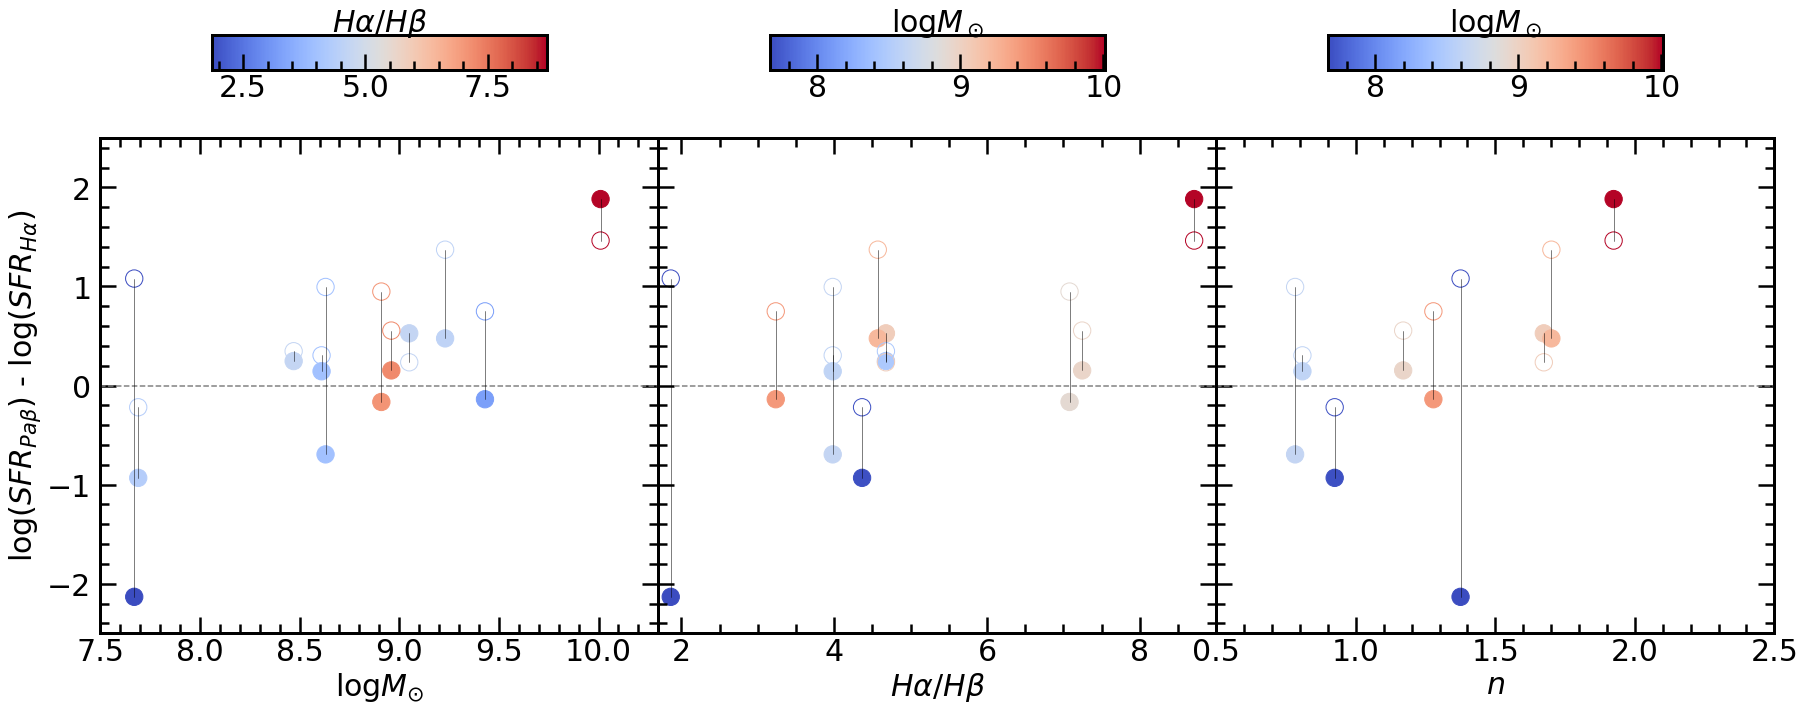

In [15]:
fig = plt.figure(figsize = (30 , 11))
gs = GridSpec(nrows=12, ncols=15)
gs.update(wspace = 0, hspace = 0.5)

ax0 = fig.add_subplot(gs[2:12, 0:5])
ax0.set_xlabel(r"log$M_{\odot}$")
y0 = ax0.scatter(dcmergedf['td_lmass'] , dcmergedf['PABHA_EXCESS_DC_BALMER']  , s = 300 , c = dcmergedf['HA_FLUX']/dcmergedf['HB_FLUX'] , cmap = 'coolwarm')
#ax0.errorbar(dcmergedf['td_lmass'] , dcmergedf['PABHA_EXCESS_DC_BALMER']  , yerr = dcmergedf['PABHA_EXCESS_DC_BALMER_ERR'], c = 'black' , linestyle = 'None')
scatterdots0 = ax0.scatter(dcmergedf['td_lmass'] , dcmergedf['PABHA_EXCESS']  , s = 300 , c = dcmergedf['HA_FLUX']/dcmergedf['HB_FLUX'] , cmap = 'coolwarm')
scatterdots0.set_facecolor('none')
ax0.plot([7.5 , 10.5] , [0 , 0] , '--' , c = 'gray')
ax0.axis([7.5 , 10.3 , -2.5 , 2.5])
ax0.set_ylabel(r'log($SFR_{Pa\beta}$) - log($SFR_{H\alpha}$)')
for i in range(len(dcmergedf)):
    ax0.plot([dcmergedf['td_lmass'].iloc[i] , dcmergedf['td_lmass'].iloc[i]] , [dcmergedf['PABHA_EXCESS'].iloc[i] , dcmergedf['PABHA_EXCESS_DC_BALMER'].iloc[i]] , c = 'black' , linewidth = .5)
 
ax1 = fig.add_subplot(gs[2:12, 5:10])  
ax1.set_xlabel(r"$H\alpha/H\beta$")
y1 = ax1.scatter(dcmergedf['HA_FLUX']/dcmergedf['HB_FLUX']  , dcmergedf['PABHA_EXCESS_DC_BALMER']  , s = 300 , c = dcmergedf['td_lmass'] , cmap = 'coolwarm')
scatterdots1 = ax1.scatter(dcmergedf['HA_FLUX']/dcmergedf['HB_FLUX'] , dcmergedf['PABHA_EXCESS']  , s = 300 , c = dcmergedf['td_lmass'] , cmap = 'coolwarm')
scatterdots1.set_facecolor('none')
#axs[0].errorbar(hamergedf['HA_FLUX'] , hamergedf['PAB_FLUX'] , xerr = hamergedf['HA_FLUX_ERR'] , yerr = hamergedf['PAB_FLUX_ERR'] ,c = 'black' , linestyle = 'None')
ax1.plot([1.9 , 9] , [0 , 0] , '--' , c = 'gray')
ax1.axis([1.7 , 9 , -2.5 , 2.5])
ax1.tick_params(labelleft = False)
for i in range(len(dcmergedf)):
    ax1.plot([dcmergedf['HA_FLUX'].iloc[i]/dcmergedf['HB_FLUX'].iloc[i] , dcmergedf['HA_FLUX'].iloc[i]/dcmergedf['HB_FLUX'].iloc[i]] , [dcmergedf['PABHA_EXCESS'].iloc[i] , dcmergedf['PABHA_EXCESS_DC_BALMER'].iloc[i]] , c = 'black' , linewidth = .5)
       
ax2 = fig.add_subplot(gs[2:12, 10:15])
ax2.set_xlabel(r"$n$")
y2 = ax2.scatter(dcmergedf['gf_n_j']  , dcmergedf['PABHA_EXCESS_DC_BALMER']  , s = 300 , c = dcmergedf['td_lmass'] , cmap = 'coolwarm')
scatterdots2 = ax2.scatter(dcmergedf['gf_n_j']  , dcmergedf['PABHA_EXCESS']  , s = 300 , c = dcmergedf['td_lmass'] , cmap = 'coolwarm')
scatterdots2.set_facecolor('none')
ax2.plot([.5 , 2.5] , [0 , 0] , '--' , c = 'gray')
ax2.axis([.5 , 2.5 , -2.5 , 2.5])
ax2.tick_params(labelleft = False)
for i in range(len(dcmergedf)):
    ax2.plot([dcmergedf['gf_n_j'].iloc[i] ,dcmergedf['gf_n_j'].iloc[i]] , [dcmergedf['PABHA_EXCESS'].iloc[i] , dcmergedf['PABHA_EXCESS_DC_BALMER'].iloc[i]] , c = 'black' , linewidth = .5)
            
                                                                                    
ax3 = fig.add_subplot(gs[0:1,1:4])
fig.colorbar(y0,ax3,use_gridspec=True,orientation='horizontal' ,  label = r'$H\alpha/H\beta$')
ax3.xaxis.set_label_position('top')
ax4 = fig.add_subplot(gs[0:1,6:9])
fig.colorbar(y1,ax4,use_gridspec=True,orientation='horizontal' ,  label = r'log$M_\odot$')
ax4.xaxis.set_label_position('top')
ax5 = fig.add_subplot(gs[0:1,11:14])
cb2 = fig.colorbar(y2,ax5,use_gridspec=True,orientation='horizontal' ,  label = r'log$M_\odot$')
ax5.xaxis.set_label_position('top')

#fig.text(0.5,0.04, r"$F_{H\alpha}$ [$erg/s/cm^2$]", ha="center", va="center")
plt.show()